In [1]:
import norse
norse.__version__

'0.0.7'

## 1. Simulating Neurons

### 1.1. Defining first neuron model

Leaky Integrate and Fire model is described as below ODE:

$$\tau_m \frac{du}{dt} = -[u(t) - u_\text{rest}] + RI(t)$$

We change the notation $u(t) \rightarrow v,~u_\text{rest} \rightarrow v_\text{leak},~\tau_m\rightarrow \tau_\text{mem}$

$$\dot{v} = \frac{1}{\tau_{\text{mem}}} (v_\text{leak} - v) + \frac{R}{\tau_\text{mem}}I(t)$$

\begin{align}
\dot{v} &= \frac{1}{\tau_{\text{mem}}} (v_\text{leak} - v + i) \\
\dot{i} &= -\frac{1}{\tau_{\text{syn}}}i
\end{align}

In [2]:
activation = norse.torch.LI()
activation

LI(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)

### 1.2. Defining input spikes

In [3]:
import torch

data = torch.zeros(1000, 1)
data[20] = 1.0
data[100] = 1.0

voltage_trace, _ = activation(data)

In [4]:
voltage_trace.shape

torch.Size([1000, 1])

### 1.3. Visualizing neuron voltage

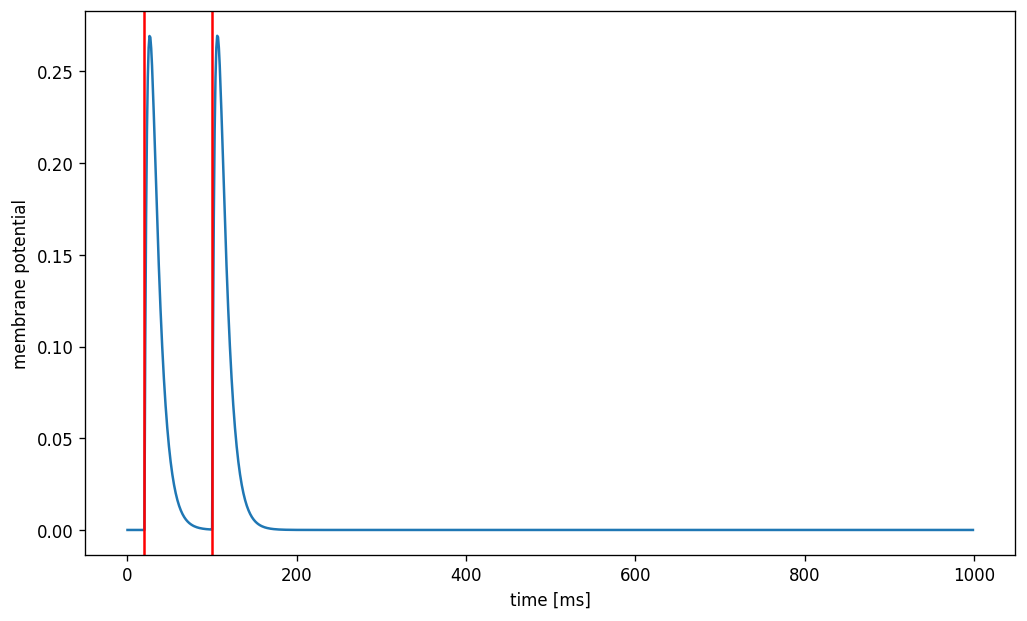

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=120)
plt.plot(voltage_trace.detach())
plt.axvline(20, color='red')
plt.axvline(100, color='red')
plt.xlabel('time [ms]')
plt.ylabel('membrane potential')
plt.show()

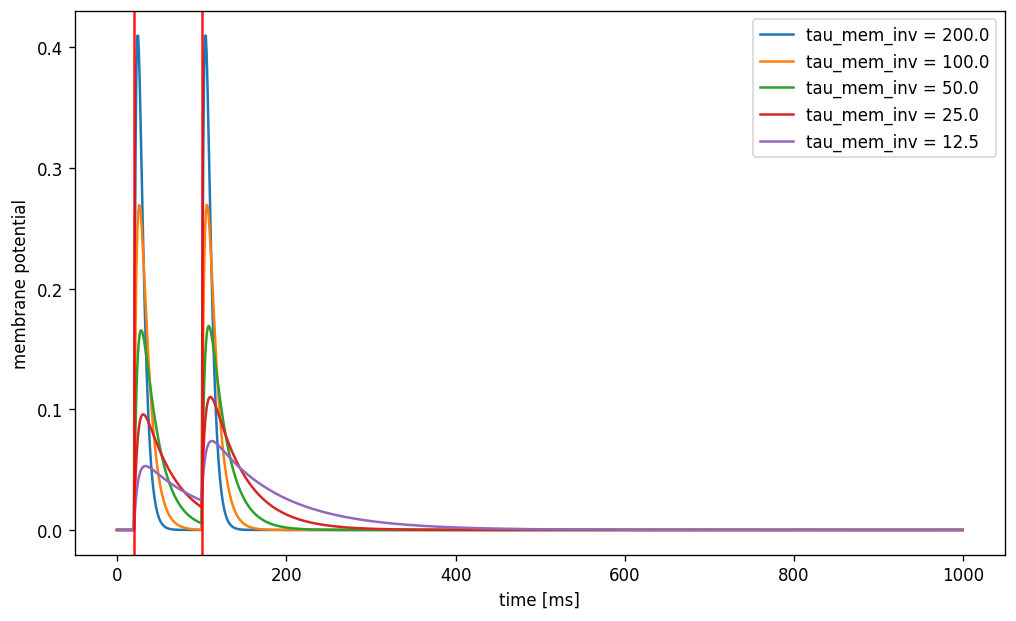

In [6]:
import norse.torch.module as nm

num_neurons = 5
tau_mem_inv = torch.tensor([200, 100, 50, 25, 12.5])
data = torch.zeros(1000, num_neurons)
data[20] = 1.0
data[100] = 1.0

voltage_trace, _ = nm.LI(
    p=nm.LIParameters(
        tau_mem_inv=tau_mem_inv, 
        tau_syn_inv=torch.tensor(200) 
    )
)(data)

plt.figure(figsize=(10, 6), dpi=120)
plt.xlabel('time [ms]')
plt.ylabel('membrane potential')
for i in range(num_neurons):
    plt.plot(voltage_trace.detach()[:,i], label=f'tau_mem_inv = {tau_mem_inv[i]}')
plt.axvline(20, color='red', alpha=0.9)
plt.axvline(100, color='red', alpha=0.9)
plt.legend()
plt.show()

The membrane time constant $\tau_\text{mem}$ is increased (`tau_mem_inv` decreased), the decay of the membrane voltage is slower.

## 2. Spiking Neuron

In [7]:
def integrate_and_record(cell):
    def integrate(input_spike_train):
        T = input_spike_train.shape[0]
        s = None
        spikes = []
        voltage_trace = []
        
        for ts in range(T):
            z, s = cell(input_spike_train[ts], s)
            spikes.append(z)
            voltage_trace.append(s.v)
        return torch.stack(spikes), torch.stack(voltage_trace)
    return integrate

In [8]:
v_th = 0.4
cell = nm.LIFCell(
    p=nm.LIFParameters(
        tau_mem_inv=torch.tensor(20), 
        tau_syn_inv=torch.tensor(50),
        v_th=torch.as_tensor(v_th)
    )
)
lif_integrate = integrate_and_record(cell)
cell

LIFCell(p=LIFParameters(tau_syn_inv=tensor(50), tau_mem_inv=tensor(20), v_leak=tensor(0.), v_th=tensor(0.4000), v_reset=tensor(0.), method='super', alpha=tensor(100.)), dt=0.001)

In [9]:
num_neurons = 1
tau_syn_inv = torch.tensor([20])
data = torch.zeros(1000, num_neurons)
data[20] = 1.0
data[100] = 1.0
data[130] = 1.0

voltage_trace, _ = nm.LI(
    p=nm.LIParameters(
        tau_mem_inv=tau_syn_inv,
        tau_syn_inv=torch.tensor(50)
    )
)(data)

zs, lif_voltage_trace = lif_integrate(data)

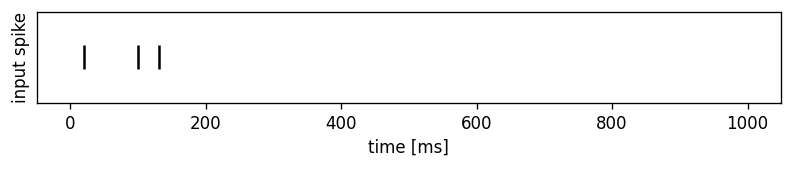

In [10]:
plt.figure(figsize=(8, 1), dpi=120)
plt.scatter(torch.arange(0,len(data)), data, s=200, c='k', marker='|')
plt.xlabel("time [ms]")
plt.ylabel("input spike")
plt.ylim([0.5, 1.5])
plt.yticks([])
plt.show()

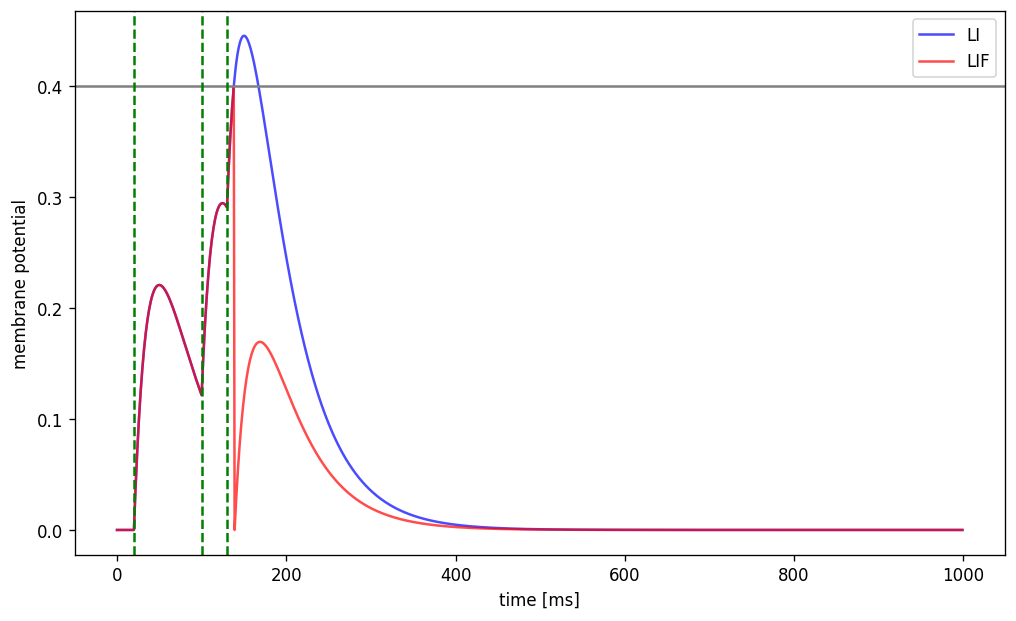

In [11]:
plt.figure(figsize=(10, 6), dpi=120)
plt.xlabel('time [ms]')
plt.ylabel('membrane potential')
plt.plot(voltage_trace.detach(), color='blue', alpha=0.7, label="LI")
plt.plot(lif_voltage_trace.detach(), color='red', alpha=0.7, label="LIF")
plt.axhline(0.4, color='grey')
plt.axvline(20, color='green', linestyle='dashed')
plt.axvline(100, color='green', linestyle='dashed')
plt.axvline(130, color='green', linestyle='dashed')
plt.legend()
plt.show()

## 3. Encoding Data Into Spikes

In [12]:
T = 10
example_encoder = nm.ConstantCurrentLIFEncoder(T)

In [13]:
data = torch.Tensor([5])

In [14]:
seq_data = torch.ones(T, 1) * data # Constant Current [5, 5, 5...,5]

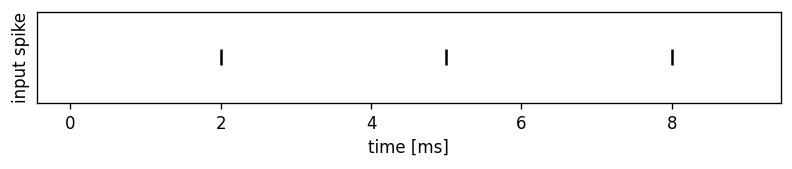

In [35]:
plt.figure(figsize=(8,1), dpi=120)
plt.scatter(
    range(T), 
    example_encoder(data).squeeze(),
    s = 100,
    c = 'k',
    marker='|'
)
plt.ylim([0.5, 1.5])
plt.yticks([])
plt.xlabel('time [ms]')
plt.ylabel('input spike')
plt.show()

In [17]:
from norse.torch.functional.encode import lif_current_encoder

`lif_current_encoder` solves below ODE

\begin{align*}
    \dot{v} &= \frac{1}{\tau_{\text{mem}}} (v_{\text{leak}} - v + i) \\
    \dot{i} &= \frac{-1}{\tau_{\text{syn}}} i
\end{align*}

In [26]:
z = torch.tensor(0.) # Spike
v = torch.tensor(0.) # Initial voltage
spikes = torch.zeros_like(seq_data) # Record spike

for ts in range(len(seq_data)):
    z, v = lif_current_encoder(
        input_current=seq_data[ts],
        voltage=v,
        p=example_encoder.p
    )
    spikes[ts] = z

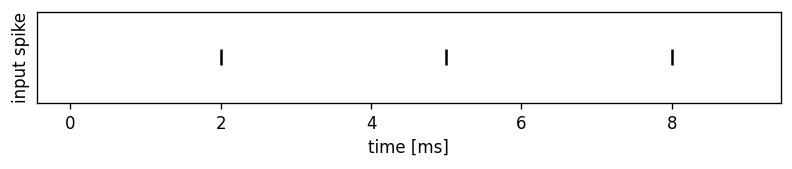

In [36]:
plt.figure(figsize=(8,1), dpi=120)
plt.scatter(
    range(T), 
    spikes,
    s = 100,
    c = 'k',
    marker='|'
)
plt.ylim([0.5, 1.5])
plt.yticks([])
plt.xlabel('time [ms]')
plt.ylabel('input spike')
plt.show()